# Import necessary packages

In [16]:
import torch
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

# Plot of closing price

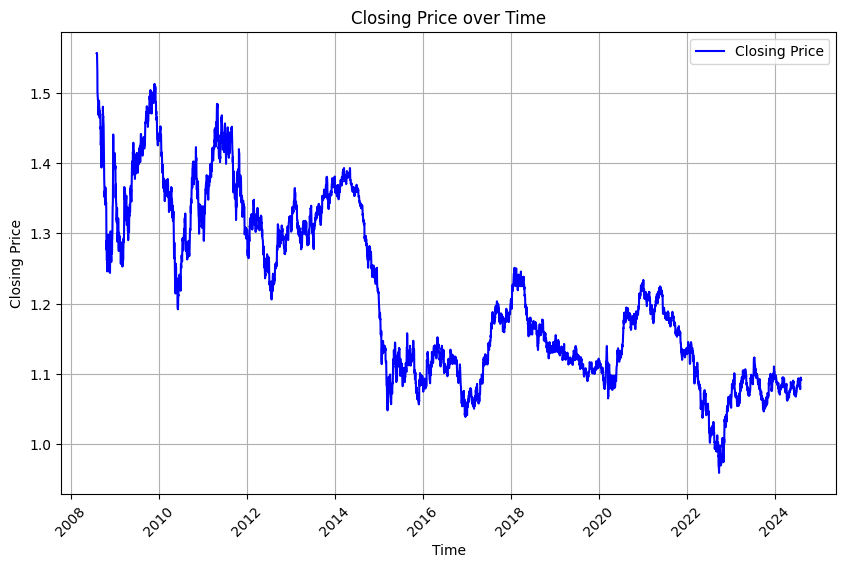

In [17]:
file_path = './Data/EURUSD_D1.csv'  # Replace with your actual file path
data = pd.read_csv(file_path)

data['Time'] = pd.to_datetime(data['Time'],format='%Y-%m-%d %H:%M:%S')

# Extract Time and Close columns
time_data = data['Time'].values  # Numpy array of time values
close_data = data['Close'].values  # Numpy array of closing prices

# Optionally, convert the closing prices to a PyTorch tensor
close_tensor = torch.tensor(close_data, dtype=torch.float32)

# Plot the closing price over time using matplotlib
plt.figure(figsize=(10, 6))
plt.plot(time_data, close_tensor, label="Closing Price", color='blue', linestyle='-')
plt.xlabel('Time')
plt.ylabel('Closing Price')
plt.title('Closing Price over Time')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.grid(True)
plt.legend()
plt.show()

# Data loader

In [18]:
# Data Loader
class ForexDataset(Dataset):
    def __init__(self, file_path):
        self.data = pd.read_csv(file_path)         # Load the dataset
        self.dateAndTime = pd.to_datetime(self.data['Time'],format='%Y-%m-%d %H:%M:%S')

        self.features = self.data[['Open', 'High', 'Low', 'Close']] 
        self.labels = self.data['Close'].shift(-1)  # Shift by -1 to get next period's closing price
    
        # Drop the last row since it will have a NaN label
        self.features = self.features[:-1]
        self.labels = self.labels[:-1]
        self.dateAndTime = self.dateAndTime[:-1]

        # Scale features (StandardScaler transforms the data into a numpy array)
        self.feature_scaler = StandardScaler()  # Initialize the scaler
        self.features = self.feature_scaler.fit_transform(self.features)  # Scale features
    
    def __len__(self):
        return len(self.features)  # Return the number of samples
    
    def __getitem__(self, idx):
        # Get the features and labels as tensors
        feature = torch.tensor(self.features[idx], dtype=torch.float32)
        label = torch.tensor(self.labels[idx], dtype=torch.float32)
        date_time = str(self.dateAndTime[idx])  # Return the datetime value as string - pytorch does not support pandas datetime object

        return feature, label, date_time

#select one feature
def featureEngineering(data, n_past=1):
    X = []
    Y= []
    for i in range(n_past, len(data)):
        X.append(data.iloc[i-n_past:i, -2].values)  # Select n_past number of rows for the closing price
        Y.append(data.iloc[i, -2])  # The target value

    feature_columns = [f'n_previous_{i}' for i in range(1, n_past+1)]
    X_df = pd.DataFrame(X, columns=feature_columns)
    Y_df = pd.DataFrame(Y, columns=['response'])

    updatedDataset = pd.concat([X_df, Y_df], axis=1)

    return updatedDataset, X_df,Y_df

# Loading the dataset and creating the dataloader
file_path = './Data/EURUSD_D1.csv'  # Replace with your actual file path
dataset = ForexDataset(file_path)

dataloader = DataLoader(dataset, batch_size=32, shuffle=False) # Create DataLoader for batch processing - will load batches of data


for batch_idx, (features, labels, dates) in enumerate(dataloader):
    print(f"Batch {batch_idx + 1}")
    print(f"Features: {features}")
    print(f"Labels (Next Close Price): {labels}")



AttributeError: 'ForexDataset' object has no attribute 'dateAndTime'

# Forward propagation

Actual closing: tensor([1.5566, 1.5564, 1.5464, 1.5419, 1.5311, 1.5003, 1.4932, 1.4912, 1.4891,
        1.4896, 1.4773, 1.4686, 1.4699, 1.4694, 1.4791, 1.4750, 1.4887, 1.4791,
        1.4780, 1.4724, 1.4643, 1.4743, 1.4701, 1.4671, 1.4697, 1.4581, 1.4487,
        1.4513, 1.4257, 1.4267, 1.4352, 1.4133])
Predicted close: tensor([[26.6999],
        [26.8386],
        [26.9356],
        [26.2568],
        [25.8057],
        [25.2477],
        [23.1424],
        [21.6755],
        [21.6793],
        [21.1288],
        [21.2401],
        [20.7007],
        [19.7254],
        [19.5905],
        [19.6356],
        [19.7526],
        [19.9110],
        [20.5797],
        [20.5925],
        [20.2762],
        [19.9519],
        [19.1562],
        [19.5987],
        [19.8075],
        [19.5053],
        [19.5338],
        [18.9279],
        [18.1028],
        [17.6025],
        [16.6897],
        [15.9245],
        [16.4283]], grad_fn=<AddBackward0>)


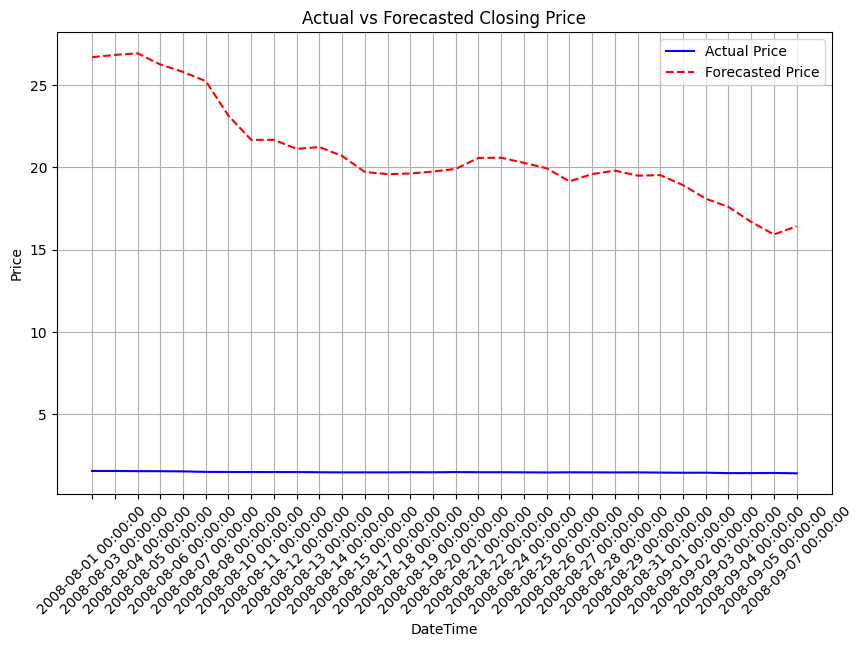

In [ ]:
# Define input size (number of features), hidden layer size, and output size
input_size = 4  # Open, High, Low, Close, Volume
hidden_size = 10  # 3 neurons in the hidden layer
output_size = 1  # Forecasted closing price

torch.manual_seed(42)  # For reproducibility

# Weights and biases for the hidden layer
W_hidden = torch.randn(input_size, hidden_size, requires_grad=True)  
# W_hidden = torch.tensor([[1, 0.5, 0.4],[0.3, 1.5, 0.4],[1, 0.4, 0.5],[0.9, 0.8,0.2]], requires_grad=True)
b_hidden = torch.randn(hidden_size, requires_grad=True)  
# b_hidden = torch.tensor([0.5, 0.3, 0.9], requires_grad=True)

# Weights and biases for the output layer
W_output = torch.randn(hidden_size, output_size, requires_grad=True) 
# W_output = torch.tensor([0.6, 0.7, 0.5], requires_grad=True)
b_output = torch.randn(output_size, requires_grad=True)  # Bias for the output layer
# b_output = torch.tensor(0.7, requires_grad=True)


def relu(x):
    return torch.max(torch.tensor(0.0), x)

# Forward propagation for a single batch of features
def forward(features):
    # Hidden layer: input -> hidden (Linear + ReLU activation)
    hidden_layer = features @ W_hidden + b_hidden  # Linear transformation (input -> hidden)
    activated_hidden = relu(hidden_layer)  # Apply ReLU activation

    # Output layer: hidden -> output (Linear, no activation for regression)
    output = activated_hidden @ W_output + b_output  # Linear transformation (hidden -> output)
    
    return output

def loss_function(y_true, y_pred):
    return ((y_true - y_pred) ** 2).mean()  # Mean squared error

actual_prices = []
predicted_prices = []
timestamps = []

# Run forward propagation on the dataset and store the results
for batch_idx, (features, labels, date_times) in enumerate(dataloader):

    predicted_close = forward(features) #forward propagation, current batch

    # Store actual and predicted prices along with timestamps
    actual_prices.extend(labels.tolist())  # Add actual closing prices
    predicted_prices.extend(predicted_close.detach().tolist())  # Add predicted closing prices
    timestamps.extend(date_times)  # date_times are already strings, no need for .tolist()

    print(f"Actual closing: {labels}")
    print(f"Predicted close: {predicted_close}")

    # For demonstration, break after the first batch (remove this in actual use case)
    break

# Plotting actual vs predicted prices with timestamps as strings
plt.figure(figsize=(10, 6))
plt.plot(timestamps, actual_prices, label="Actual Price", color='blue', linestyle='-')
plt.plot(timestamps, predicted_prices, label="Forecasted Price", color='red', linestyle='--')
plt.xlabel('DateTime')
plt.ylabel('Price')
plt.title('Actual vs Forecasted Closing Price')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.show()



# BackPropagation and weight update

Batch 1, Loss: 385.91058349609375
Updated W_hidden: tensor([[ 1.9269,  0.6126,  0.9007, -1.9318,  1.3322, -1.5538, -1.7371, -1.6047,
         -0.7521,  1.3805],
        [-0.3925, -2.2737, -0.7279, -0.3865, -0.1185,  0.4448, -0.0429, -0.1596,
         -0.4974,  0.1727],
        [-0.7581,  0.2087,  0.8008,  1.8538,  0.6849,  0.0037, -0.1108, -0.8455,
          1.3123,  0.4204],
        [-1.0892, -1.2186, -1.4181,  1.0683,  0.6952,  1.9516, -0.4933, -0.4345,
         -1.3864, -1.5510]], requires_grad=True)
Updated b_hidden: tensor([-0.0499,  0.1414, -0.0085,  0.8059,  0.4208,  0.7235, -1.7612, -0.8887,
         0.1498, -0.3269], requires_grad=True)
Updated W_output: tensor([[-0.3870],
        [ 0.0700],
        [ 0.4679],
        [-0.3946],
        [-0.7905],
        [-1.8096],
        [-1.4967],
        [-0.2254],
        [-0.3417],
        [-0.9381]], requires_grad=True)
Updated b_output: tensor([-1.0773], requires_grad=True)
Batch 2, Loss: 118.83848571777344
Updated W_hidden: tensor([[

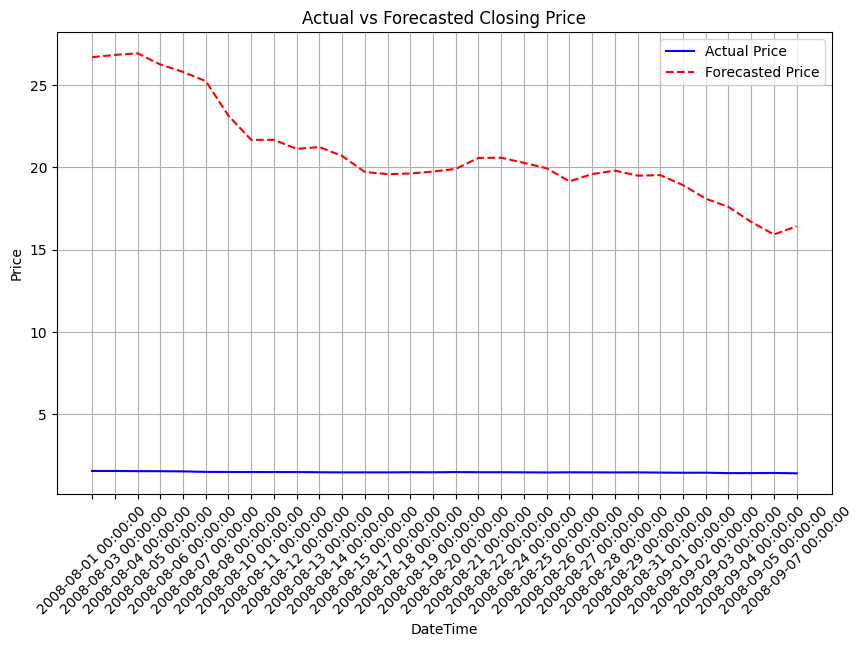

In [ ]:
# Define a learning rate
learning_rate = 0.01

# Perform forward pass, calculate loss, backpropagate gradients, and update weights
for batch_idx, (features, labels, date_times) in enumerate(dataloader):
    # Zero the gradients (required before each forward pass)
    W_hidden.grad = None
    b_hidden.grad = None
    W_output.grad = None
    b_output.grad = None

    # Forward propagation
    predicted_close = forward(features)

    # Calculate the loss
    loss = loss_function(labels, predicted_close)

    # Backpropagation: compute the gradients
    loss.backward()  # PyTorch calculates the gradients

    # Manually update the weights using gradient descent
    with torch.no_grad():  # Disable gradient tracking during weight updates
        W_hidden -= learning_rate * W_hidden.grad
        b_hidden -= learning_rate * b_hidden.grad
        W_output -= learning_rate * W_output.grad
        b_output -= learning_rate * b_output.grad

    # Print loss and weight updates for the current batch
    print(f"Batch {batch_idx + 1}, Loss: {loss.item()}")
    print(f"Updated W_hidden: {W_hidden}")
    print(f"Updated b_hidden: {b_hidden}")
    print(f"Updated W_output: {W_output}")
    print(f"Updated b_output: {b_output}")

    # break  # Running on the first batch for demonstration

# Plotting actual vs predicted prices with timestamps as strings
plt.figure(figsize=(10, 6))
plt.plot(timestamps, actual_prices, label="Actual Price", color='blue', linestyle='-')
plt.plot(timestamps, predicted_prices, label="Forecasted Price", color='red', linestyle='--')
plt.xlabel('DateTime')
plt.ylabel('Price')
plt.title('Actual vs Forecasted Closing Price')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.show()

